# Data Visualizations

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob

def visualize_multiple_csvs_as_video(csv_folder, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())
    if max_frames is not None:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')

    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')

        road_width = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_width / 2),
                                (df['X'].max() - df['X'].min()) + 40,
                                road_width, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_width / 2, df['Y'].min() - 20),
                                road_width,
                                (df['Y'].max() - df['Y'].min()) + 40,
                                color='lightgray', zorder=0))

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])             
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


In [4]:
import os
print(os.environ.get("SUMO_HOME"))


C:\Program Files (x86)\Eclipse\Sumo\


Video saved to simple_inclined_10m_intersection.mp4


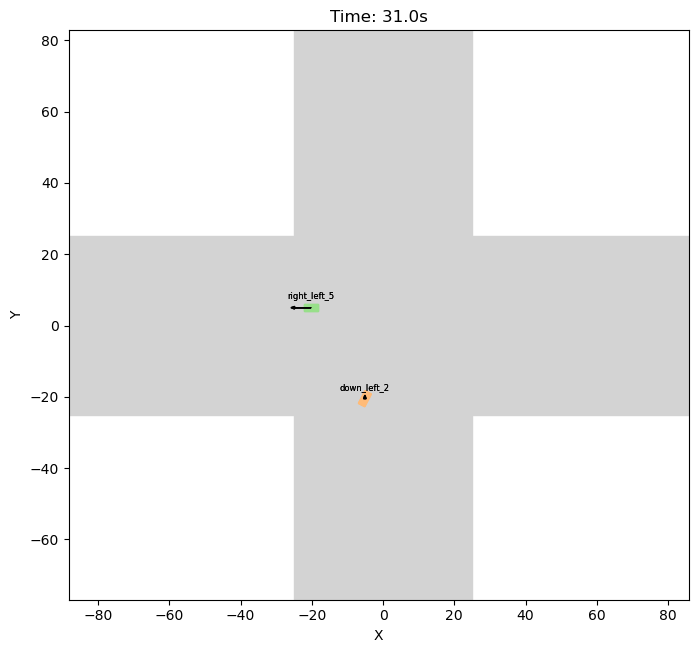

In [5]:
path_to_csv_data = r'MTP/csv/train_inclined_10m'
output_video_name = "simple_inclined_10m_intersection.mp4"

visualize_multiple_csvs_as_video(
    csv_folder=path_to_csv_data,
    output_video_path=output_video_name,
    interval_ms=100,
    max_frames=250  # optional lenght of the video in frames (None for all frames)
)
